# Install spark and import libraries

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=c5c80673e26bff991e9215b8db7ec90b4cd4b69fee9d5bd604c045c4d8453e5a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pyspark
import urllib.parse
import requests
import os
from pyspark.sql.types import *
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder  #int -> dummy
from pyspark.ml.feature import VectorAssembler #build a vector from columns
from pyspark.ml.pipeline import Pipeline 
from pyspark.ml.regression import LinearRegression

In [ ]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
spark #check spark session

# Data Collection

## Download data from github and save to file system

In [ ]:
linkSource = "https://raw.githubusercontent.com/rvm-courses/GasPrices/master/"
fromYear=2019
toYear=2021
mainFile="Prix*.csv.gz"
otherFiles=["Stations2022.csv.gz","Services2022.csv.gz"]
directory="Data"

In [ ]:
def downloadFile(filename,linkSource,targetDirectory):
  '''
  download filename from website (linksource) to the target directory
  '''
  url=urllib.parse.urljoin(linkSource, filename)
  targetFile= os.path.join(targetDirectory,filename)

  with open(targetFile, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

In [ ]:
def downloadData():
  '''
  Dowload all the files specified: prices files for certain years and stations and services in 2022
  '''
  targetDirectory=os.path.join(os.getcwd(),directory)
  if not os.path.exists(targetDirectory): 
    os.makedirs(targetDirectory)
  #download Price files
  for year in range(fromYear,toYear+1):
    filename=mainFile.replace("*",str(year))
    downloadFile(filename,linkSource,targetDirectory)

  #download Other files
  for filename in otherFiles:
    downloadFile(filename,linkSource,targetDirectory)

In [ ]:
# Download files and show directory
downloadData()
!ls ./Data

Prix2019.csv.gz  Prix2021.csv.gz      Stations2022.csv.gz
Prix2020.csv.gz  Services2022.csv.gz


## Import data in to spark

In [ ]:
# Manually create schema
priceFiles=["Data/Prix*.csv.gz".replace("*",str(year)) for year in range(fromYear,toYear+1)]
schema = StructType() \
      .add("IdPDV",IntegerType(),True) \
      .add("Zipcode",IntegerType(),True) \
      .add("PopType",StringType(),True) \
      .add("Lat",DoubleType(),True) \
      .add("Long",DoubleType(),True) \
      .add("Date",TimestampType(),True) \
      .add("IdGas",IntegerType(),True)\
      .add("LabGas",StringType(),True)\
      .add("Price",DoubleType(),True) \
#import the data      
prices_ddf_raw = spark.read.csv(priceFiles, sep  = ';', header=False,schema=schema)

In [ ]:
#show that data is imported correctly
prices_ddf_raw.show(5)
prices_ddf_raw.printSchema()

+-------+-------+-------+---------+--------+-------------------+-----+------+------+
|  IdPDV|Zipcode|PopType|      Lat|    Long|               Date|IdGas|LabGas| Price|
+-------+-------+-------+---------+--------+-------------------+-----+------+------+
|1000001|   1000|      R|4620114.0|519791.0|2021-01-02 15:13:25|    1|Gazole|1252.0|
|1000001|   1000|      R|4620114.0|519791.0|2021-01-04 09:28:43|    1|Gazole|1268.0|
|1000001|   1000|      R|4620114.0|519791.0|2021-01-06 09:29:19|    1|Gazole|1268.0|
|1000001|   1000|      R|4620114.0|519791.0|2021-01-06 15:45:51|    1|Gazole|1268.0|
|1000001|   1000|      R|4620114.0|519791.0|2021-01-07 09:44:40|    1|Gazole|1273.0|
+-------+-------+-------+---------+--------+-------------------+-----+------+------+
only showing top 5 rows

root
 |-- IdPDV: integer (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- PopType: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Date: timest

# Prepare Data

## Add and change variables

In [ ]:
prices_ddf=prices_ddf_raw.withColumn("Year", F.year(F.col("Date")))\
    .withColumn("Month", F.month(F.col("Date")))\
    .withColumn("Week", F.weekofyear(F.col("Date")))\
    .withColumn("Lat",F.col("Lat")/100000)\
    .withColumn("Long",F.col("Long")/100000)\
    .withColumn("Day", F.to_date(F.col("Date")))
prices_ddf.cache() 

DataFrame[IdPDV: int, Zipcode: int, PopType: string, Lat: double, Long: double, Date: timestamp, IdGas: int, LabGas: string, Price: double, Year: int, Month: int, Week: int, Day: date]

In [ ]:
prices_ddf.show(10)

+-------+-------+-------+--------+-------+-------------------+-----+------+------+----+-----+----+----------+
|  IdPDV|Zipcode|PopType|     Lat|   Long|               Date|IdGas|LabGas| Price|Year|Month|Week|       Day|
+-------+-------+-------+--------+-------+-------------------+-----+------+------+----+-----+----+----------+
|1000001|   1000|      R|46.20114|5.19791|2021-01-02 15:13:25|    1|Gazole|1252.0|2021|    1|  53|2021-01-02|
|1000001|   1000|      R|46.20114|5.19791|2021-01-04 09:28:43|    1|Gazole|1268.0|2021|    1|   1|2021-01-04|
|1000001|   1000|      R|46.20114|5.19791|2021-01-06 09:29:19|    1|Gazole|1268.0|2021|    1|   1|2021-01-06|
|1000001|   1000|      R|46.20114|5.19791|2021-01-06 15:45:51|    1|Gazole|1268.0|2021|    1|   1|2021-01-06|
|1000001|   1000|      R|46.20114|5.19791|2021-01-07 09:44:40|    1|Gazole|1273.0|2021|    1|   1|2021-01-07|
|1000001|   1000|      R|46.20114|5.19791|2021-01-08 10:20:52|    1|Gazole|1274.0|2021|    1|   1|2021-01-08|
|1000001| 

In [ ]:
prices_ddf.createOrReplaceTempView("prices")

## Create Price and week index

In [ ]:
#using create average daily price using pyspark commands
dayPrice_ddf=prices_ddf.groupby("Day")\
        .agg(F.avg(F.col("Price")).alias("average"))

In [ ]:
#using create average daily price using sql
dayPrice_ddf=spark.sql("""
SELECT Day, avg(price) as AveragePrice
FROM prices
GROUP BY Day
""")
dayPrice_ddf.createOrReplaceTempView("dayprices")

In [ ]:
#using create index using pyspark commands
indexprices_ddf=prices_ddf.join(dayPrice_ddf,on=["Day"],how='inner')\
      .withColumn("PriceIndex",100*((F.col("Price")-F.col("AveragePrice"))/F.col("AveragePrice")+1))


In [ ]:
#using create index using sql commands
indexprices_ddf= spark.sql("""
SELECT A.*, 100*((Price-AveragePrice)/AveragePrice +1) as priceIndex
FROM prices A
LEFT JOIN dayprices B
ON A.Day = B.Day
ORDER BY Day DESC
""")
indexprices_ddf.createOrReplaceTempView("indexprices")

In [ ]:
#test to see if index works as expected
indexprices_ddf.show(5)

+-------+-------+-------+------+-----+-------------------+-----+------+------+----+-----+----+----------+------------------+
|  IdPDV|Zipcode|PopType|   Lat| Long|               Date|IdGas|LabGas| Price|Year|Month|Week|       Day|        priceIndex|
+-------+-------+-------+------+-----+-------------------+-----+------+------+----+-----+----+----------+------------------+
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    1|Gazole|1520.0|2021|   12|  52|2021-12-31| 103.1026724216463|
|1000012|   1000|      R|46.201|  5.2|2021-12-31 00:01:00|    3|   E85| 719.0|2021|   12|  52|2021-12-31| 48.77027728366032|
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    2|  SP95|1609.0|2021|   12|  52|2021-12-31|109.13960521475585|
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    5|   E10|1577.0|2021|   12|  52|2021-12-31|106.96902263745804|
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    6|  SP98|1652.0|2021|   12|  52|2021-12-31|112.05632555299981|


In [ ]:
#determine the first day in order to set the week index from that day
firstDay = prices_ddf.agg({"Date": "min"}).collect()[0]

In [ ]:
#Create weekindex using SQL
indexprices_ddf=spark.sql("""
SELECT indexprices.*, ceil(datediff(Day,FirstDay)/7+1) AS weekIndex
FROM indexprices,(SELECT min(Day) as FirstDay
                  FROM indexprices)
ORDER BY Day DESC
""")
indexprices_ddf.createOrReplaceTempView("indexprices")

In [ ]:
indexprices_ddf.show(5)

+-------+-------+-------+------+-----+-------------------+-----+------+------+----+-----+----+----------+------------------+---------+
|  IdPDV|Zipcode|PopType|   Lat| Long|               Date|IdGas|LabGas| Price|Year|Month|Week|       Day|        priceIndex|weekIndex|
+-------+-------+-------+------+-----+-------------------+-----+------+------+----+-----+----+----------+------------------+---------+
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    6|  SP98|1652.0|2021|   12|  52|2021-12-31|112.05632555299981|      158|
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    2|  SP95|1609.0|2021|   12|  52|2021-12-31|109.13960521475585|      158|
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    5|   E10|1577.0|2021|   12|  52|2021-12-31|106.96902263745804|      158|
|1000008|   1000|      R|46.199|5.241|2021-12-31 00:25:00|    1|Gazole|1520.0|2021|   12|  52|2021-12-31| 103.1026724216463|      158|
|1000012|   1000|      R|46.201|  5.2|2021-12-31 00:01:

# Visualize Data

In [ ]:
#Collect data necessary for plotting
dataPriceVisualization=spark.sql("""
SELECT  LabGas,weekIndex, avg(price) as AveragePrice
FROM indexprices
GROUP BY weekIndex, LabGas 
""").toPandas()

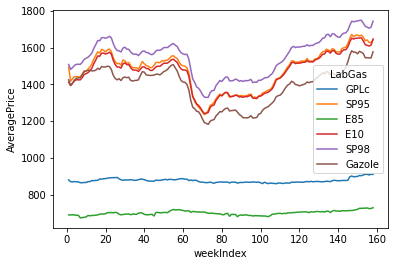

In [ ]:
#Create simple seaborn line plot
sns.lineplot(x = "weekIndex", y = "AveragePrice", hue = "LabGas", data = dataPriceVisualization)

# Model Price evolution

In [ ]:
# check which variables could function as explanatory dummy variables
indexprices_ddf.select(F.countDistinct("PopType"),
                       F.countDistinct("IdGas"),
                       F.countDistinct("ZipCode"),).show()

+-----------------------+---------------------+-----------------------+
|count(DISTINCT PopType)|count(DISTINCT IdGas)|count(DISTINCT ZipCode)|
+-----------------------+---------------------+-----------------------+
|                      3|                    6|                   4396|
+-----------------------+---------------------+-----------------------+



We do not use zipcodes since they have to many distinct values. Instead we will only consider Gas Id

In [ ]:
#We show that we do not have a price for every day at every station
spark.sql("""
SELECT IdPDV,IdGas,Day,count(price)
FROM indexprices
GROUP BY IdPDV, IdGas, Day
""").show()

+-------+-----+----------+------------+
|  IdPDV|IdGas|       Day|count(price)|
+-------+-----+----------+------------+
|1000001|    1|2019-01-04|           1|
|1000001|    1|2019-01-07|           1|
|1000001|    1|2019-01-10|           1|
|1000001|    1|2019-01-17|           1|
|1000001|    1|2019-01-26|           2|
|1000001|    1|2019-02-01|           1|
|1000001|    1|2019-02-08|           1|
|1000001|    1|2019-02-11|           1|
|1000001|    1|2019-02-19|           1|
|1000001|    1|2019-02-20|           1|
|1000001|    1|2019-02-22|           2|
|1000001|    1|2019-02-25|           1|
|1000001|    1|2019-02-28|           1|
|1000001|    1|2019-03-09|           1|
|1000001|    1|2019-03-11|           1|
|1000001|    1|2019-03-13|           1|
|1000001|    1|2019-03-26|           1|
|1000001|    1|2019-03-27|           1|
|1000001|    1|2019-03-28|           1|
|1000001|    1|2019-03-29|           1|
+-------+-----+----------+------------+
only showing top 20 rows



Since we do not have a price at every station for every day, we will instead model the average prices at each day (seperated by gas type)

In [ ]:
#Show Example ot target variable Price per gas type
regression_ddf=spark.sql("""
SELECT IdGas,Day,avg(price) as NationalPrice
FROM indexprices
GROUP BY IdGas, Day
""")
regression_ddf.show()

+-----+----------+------------------+
|IdGas|       Day|     NationalPrice|
+-----+----------+------------------+
|    1|2021-12-31|1593.6616954474098|
|    2|2021-12-31| 1651.065934065934|
|    5|2021-12-31| 1658.802748585287|
|    6|2021-12-31|1759.1410788381743|
|    3|2021-12-31| 733.6639231824417|
|    4|2021-12-31| 912.7977528089888|
|    6|2021-12-30|1735.4160317986089|
|    1|2021-12-30|1571.5263312739041|
|    3|2021-12-30| 727.7678227360308|
|    5|2021-12-30|1640.8395061728395|
|    2|2021-12-30|1640.7110266159696|
|    4|2021-12-30| 907.6163410301954|
|    2|2021-12-29|1639.1112469437653|
|    1|2021-12-29|1575.5675337668833|
|    5|2021-12-29|1645.9733937163883|
|    6|2021-12-29|1743.7292439372325|
|    3|2021-12-29| 725.4872727272727|
|    4|2021-12-29| 909.6594982078853|
|    1|2021-12-28|1558.1583563016789|
|    3|2021-12-28|  724.993699369937|
+-----+----------+------------------+
only showing top 20 rows



In [ ]:
#We create the lags for the OLS using the a window function
w = Window().orderBy('IdGas',"Day")
lagRegression_ddf = regression_ddf
for i in range(1, 16): 
    lagRegression_ddf = lagRegression_ddf.withColumn(f"lag_{i}", F.lag(F.col('NationalPrice'), i).over(w))
lagRegression_ddf.show(5)
lagRegression_ddf=lagRegression_ddf.dropna()
lagRegression_ddf.show(5)

+-----+----------+------------------+------------------+------------------+------------------+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+
|IdGas|       Day|     NationalPrice|             lag_1|             lag_2|             lag_3|lag_4|lag_5|lag_6|lag_7|lag_8|lag_9|lag_10|lag_11|lag_12|lag_13|lag_14|lag_15|
+-----+----------+------------------+------------------+------------------+------------------+-----+-----+-----+-----+-----+-----+------+------+------+------+------+------+
| null|      null|              null|              null|              null|              null| null| null| null| null| null| null|  null|  null|  null|  null|  null|  null|
|    1|2019-01-01|1424.2279582366589|              null|              null|              null| null| null| null| null| null| null|  null|  null|  null|  null|  null|  null|
|    1|2019-01-02|1394.9234472797305|1424.2279582366589|              null|              null| null| null| null| null| null| null|  nul

As expected the first few variables contain null values since not all lags exists. There we drop all rows with null values

In [ ]:
#Create the list with feature names
featurecols=[f"lag_{i}" for i in range(1,16)]
featurecols.append("ohe_IdGas")
selectedfeaturecols=[f"lag_{i}" for i in range(1,4)]
selectedfeaturecols.append("ohe_IdGas")

We now create the pipeline for our features, this includes the one hot encoding for the gas type as well as the other lags.

In [ ]:
ohegas = OneHotEncoder(inputCol='IdGas',outputCol='ohe_IdGas')
featuresselection = VectorAssembler(inputCols=featurecols,outputCol="features")

pipeline=Pipeline(stages=[ohegas,featuresselection])

In [ ]:
# test the pipeline
features=pipeline.fit(lagRegression_ddf).transform(lagRegression_ddf)
features.show(5)

+-----+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+--------------------+
|IdGas|       Day|     NationalPrice|             lag_1|             lag_2|             lag_3|             lag_4|             lag_5|             lag_6|             lag_7|             lag_8|             lag_9|            lag_10|            lag_11|            lag_12|            lag_13|            lag_14|            lag_15|    ohe_IdGas|            features|
+-----+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+

To the pipeline we can add a linear regression model to perform our pooled OLS

In [ ]:
regression = LinearRegression(featuresCol='features', labelCol='NationalPrice')


In [ ]:
lrModel=regression.fit(features)

We want to evaluate our Model by looking at the OLS Coefficients and the residuals

In [ ]:
# Print the coefficients and intercept for linear regression
print(featurecols[:15])
print("Coefficients: %s" % str(lrModel.coefficients[:16]))
print(featurecols[15:])
print("Coefficients: %s" % str(lrModel.coefficients[16:]))
print("Intercept: %s" % str(lrModel.intercept))

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15']
Coefficients: [ 0.81850032  0.10469319  0.03161071  0.02561739 -0.03301236 -0.03710143
  0.25117274 -0.24166413  0.00568798  0.05904049  0.01324399 -0.04678293
 -0.04859997  0.25379735 -0.18649252  0.        ]
['ohe_IdGas']
Coefficients: [ -4.74465665  -2.26827843 -26.98695504 -20.53569466  -2.13756545]
Intercept: 47.227518469152166


We see that only the first three four lags have a large effect and we will thus consider the model with just these

In [ ]:
featuresnames2 = VectorAssembler(inputCols=selectedfeaturecols,outputCol="features")
pipeline2=Pipeline(stages=[ohegas,featuresnames2])

features2=pipeline2.fit(lagRegression_ddf).transform(lagRegression_ddf)

lrModel2=regression.fit(features2)

In [ ]:
# Print the coefficients and intercept for linear regression
print(selectedfeaturecols[:3])
print("Coefficients: %s" % str(lrModel2.coefficients[:3]))
print(selectedfeaturecols[3:])
print("Coefficients: %s" % str(lrModel2.coefficients[3:]))
print("Intercept: %s" % str(lrModel2.intercept))

['lag_1', 'lag_2', 'lag_3']
Coefficients: [0.76197855 0.11599222 0.09140126]
['ohe_IdGas']
Coefficients: [  0.          -4.77139866  -2.38308153 -27.39304839 -20.72396077
  -1.93151247]
Intercept: 47.749096631802075


In [ ]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel2.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))


numIterations: 37
objectiveHistory: [0.4999999999999991, 0.007405960011081625, 0.006097949685947235, 0.0020584884278465054, 0.0020110792918188736, 0.0019243276982372493, 0.0016420826928653653, 0.0016305716601507925, 0.0016080832602458628, 0.0014470852686221392, 0.0014162900811403034, 0.0014105218161102329, 0.0014102319046269685, 0.0014100472691360721, 0.001409337073413397, 0.0014079928185104507, 0.001405804651043674, 0.0014052116371541246, 0.001403353703497423, 0.0014031015226105836, 0.0014030840925611798, 0.0014030837196097323, 0.001403083611132061, 0.0014030836083716025, 0.001403083606795974, 0.0014030836054850226, 0.0014030836023088966, 0.0014030835951635012, 0.001403083584882836, 0.0014030835815965759, 0.0014030835756022597, 0.0014030835734146763, 0.0014030835733249702, 0.0014030835732379288, 0.0014030835731615454, 0.0014030835731455582, 0.0014030835731349, 0.0014030835731322355]


We see that our models have converged

In [ ]:
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

+-------------------+
|          residuals|
+-------------------+
|  5.777647564717654|
|   4.72930962493183|
|-2.4044077598252898|
| 7.7738838489558475|
| 11.610442556899898|
| -4.739739282393884|
|-0.8928622852431545|
|  5.280785441276748|
| 5.3888066023346255|
| -4.130021139217433|
|  4.603576923054106|
| 13.571093851968499|
|-12.987913900339208|
|  5.045282073292356|
| -2.957181562130245|
|  1.640345005719837|
| 1.7250494350805639|
| 3.4469795458689987|
|  10.78055742821789|
|  -6.93844245206401|
+-------------------+
only showing top 20 rows

RMSE: 18.160290
r2: 0.997194


We See that our R2 is quite high which indicates that the prices is potentially well fitted

Below we show the pipeline to get the prediction

In [ ]:
pipeline_reg = Pipeline(stages=[pipeline2, regression])
pipeline_reg.fit(lagRegression_ddf).transform(lagRegression_ddf).show(5)

+-----+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------+--------------------+------------------+
|IdGas|       Day|     NationalPrice|             lag_1|             lag_2|             lag_3|             lag_4|             lag_5|             lag_6|             lag_7|             lag_8|             lag_9|            lag_10|            lag_11|            lag_12|            lag_13|            lag_14|            lag_15|    ohe_IdGas|            features|        prediction|
+-----+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+